In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#def load_data(L,temp,MCS):
#    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)
def load_data(L,temp,MCS):
    return np.fromfile(f"/content/drive/MyDrive/ising_data/dataIsing2D_L10/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [22]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)
L = 10
#data = load_data(L,Ts[9],200000)
data = load_data(L,2.27,200000)

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


$\mathbf{W} = \left(\Delta_t \mathbf{1} + \mathbf{C}^0 e^{-2t}\right)^{-1}$

$\mathbf{M} = 3\Delta_t(\Delta_t + e^{-2t} ) \mathbf{1} +(3\Delta_t+e^{-2t})\mathbf{C}^0 e^{-2t} $

The equation for $g$ is:

$\text{Tr}(\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1})) - g \cdot\text{Tr}(x_i^2  (x_i^2-1)^2) + \cdots$ = 0

Let's get the matrix M and W

In [23]:
nSteps =600
dt = 0.01
diffTemp = 1
def Deltat(n,dt,diffTemp):
    return diffTemp*(1-np.exp(-2*(n+1)*dt))

In [24]:
C0 = np.cov(data.T)
W = np.empty((nSteps,data.shape[1],data.shape[1]))
invW = np.empty((nSteps,data.shape[1],data.shape[1]))
M = np.empty((nSteps,data.shape[1],data.shape[1]))
K = np.empty((nSteps,data.shape[1],data.shape[1]))
M = np.empty((nSteps,data.shape[1],data.shape[1]))

In [25]:
for t in range(nSteps):
    Dt = Deltat(t,dt,diffTemp)
    exp2t=np.exp(-2*(t+1)*dt)
    invW[t] = Dt*np.eye(data.shape[1]) + C0*exp2t
    W[t] = np.linalg.inv(invW[t])
    M[t] = (3*Dt+exp2t)*C0*exp2t+ 3*Dt*(Dt + exp2t)*np.eye(data.shape[1])

$\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1}) = \mathbf{W}\mathbf{M} - \mathbf{1} + g\cdot (-2\mathbf{M} + \mathbf{W}^{-1} + \mathbf{M}\mathbf{W}\mathbf{M}) = \mathbf{K} + g\cdot \mathbf{K_g}$

$ \mathbf{K} + g\cdot \mathbf{K_g} - g\cdot \mathbf{C}_6  - \mathbf{C_4} = 0$

In [26]:
K = np.matmul(W,M) - np.eye(W.shape[1])
K_g = -2*M + invW + np.matmul(M,np.matmul(W,M))

Now the other terms

In [27]:
ts= np.array([*range(nSteps)])
Dts = Deltat(ts,dt,diffTemp)
expts = np.exp(-2*(ts+1)*dt)
C6 = Dts*(15*Dts**2 - 6*Dts + 1) + expts *(45*Dts**2 - 12*Dts + 1) + expts**2 * (15*Dts-2) + expts**3
C4 = 3*(Dts+expts)-1

$g = -\frac{\text{Tr}(\mathbf{K}) - \mathbf{C}_4}{\text{Tr}(\mathbf{K}_g) - \mathbf{C}_6}$

In [28]:
num = np.trace(K,axis1=1,axis2=2) - 100*C4
den = np.trace(K_g,axis1=1,axis2=2) - 100*C6
g = -num/den

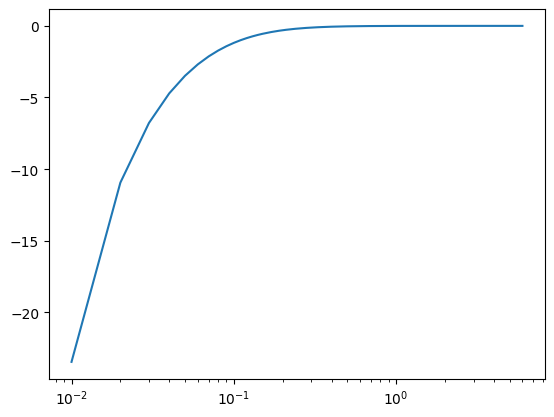

In [29]:
plt.plot((ts+1)*dt,g)
plt.xscale("log")

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


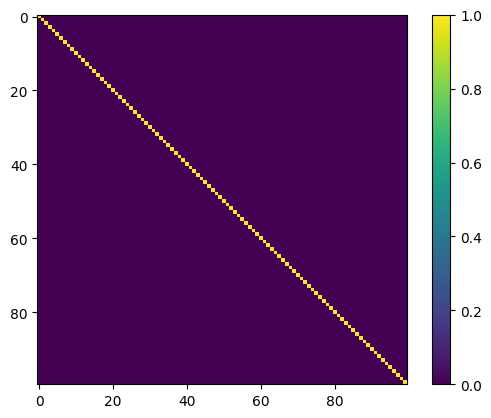

In [30]:
A =  W + g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(data.shape[1]).reshape(1,data.shape[1],data.shape[1]))
plt.imshow(A[-1])
plt.colorbar()

In [31]:
def myscore(x,A,g,device = "cuda"):
    return  -torch.matmul(x,A.T) + g*x*(x**2-1)

In [68]:
def backward(xT,A,g,temp,nSteps,dt,full_traj = False,device = "cuda"):
    P = xT.shape[0]
    N = xT.shape[1]
    A =torch.from_numpy(A).to(device).to(torch.float32)
    g =torch.from_numpy(g).to(device).to(torch.float32)
    nbatches = 100
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps,N).to(device)
        x_recon[:,-1,:] = xT.to(device)
    else:
        x_recon = xT.to(device)
    with torch.no_grad():
        for tt in range(nSteps)[::-1]:
            std = np.sqrt(2*(temp)*dt)*torch.randn_like(xT).to(device)
            den = np.sqrt(temp*(1-np.exp(-2*(tt+1))))

            for n in range(nbatches):
                if(full_traj):
                    score = 2*myscore(x_recon[n*batch_size:(n+1)*batch_size,tt,:], A[tt],g[tt],device)
                    x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                else:
                    score = 2*myscore(x_recon[n*batch_size:(n+1)*batch_size], A[tt],g[tt],device)
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score

    return x_recon.to("cpu").numpy()

In [69]:
P = 100000
N = L**2
xT = np.sqrt(diffTemp)*torch.randn((P,N))
x_recon = backward(xT,A,g,diffTemp,nSteps,dt,device= "cuda")

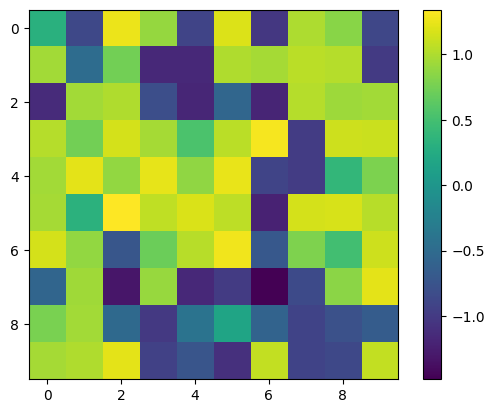

In [70]:
plt.imshow(x_recon[5000].reshape(L,L))
plt.colorbar()

(array([1.289775, 0.753075, 0.268125, 0.116275, 0.07265 , 0.09255 ,
        0.116975, 0.249975, 0.623925, 1.416675]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

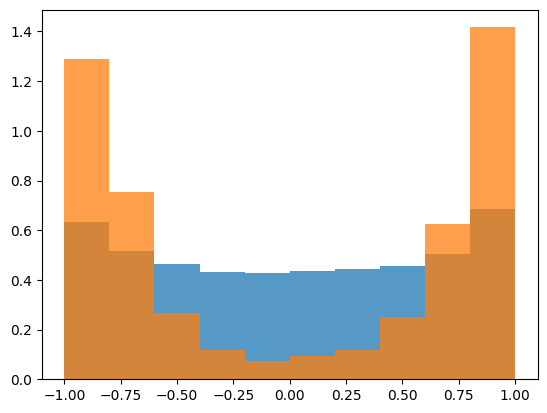

In [75]:
plt.hist(np.mean(np.sign(x_recon),axis = 1),density=True,alpha = 0.75)
plt.hist(np.mean(data,axis = 1),density=True,alpha = 0.75)

(array([1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 7.000e+00, 1.200e+01,
        1.900e+01, 5.600e+01, 8.200e+01, 1.620e+02, 2.870e+02, 4.390e+02,
        6.420e+02, 9.900e+02, 1.412e+03, 1.808e+03, 2.169e+03, 2.725e+03,
        2.979e+03, 3.183e+03, 3.329e+03, 3.385e+03, 3.150e+03, 2.922e+03,
        2.598e+03, 2.326e+03, 1.986e+03, 1.702e+03, 1.404e+03, 1.245e+03,
        1.080e+03, 8.630e+02, 7.410e+02, 6.750e+02, 5.740e+02, 4.610e+02,
        4.660e+02, 4.040e+02, 3.880e+02, 3.620e+02, 3.520e+02, 3.570e+02,
        3.100e+02, 2.890e+02, 2.920e+02, 2.600e+02, 2.680e+02, 2.690e+02,
        2.510e+02, 2.600e+02, 2.650e+02, 2.570e+02, 2.380e+02, 2.350e+02,
        2.700e+02, 2.410e+02, 2.590e+02, 2.460e+02, 2.840e+02, 3.350e+02,
        3.200e+02, 3.580e+02, 3.530e+02, 3.560e+02, 4.450e+02, 4.720e+02,
        4.810e+02, 5.690e+02, 6.470e+02, 7.320e+02, 7.990e+02, 9.850e+02,
        1.154e+03, 1.372e+03, 1.616e+03, 1.881e+03, 2.240e+03, 2.560e+03,
        2.749e+03, 3.096e+03, 3.311e+0

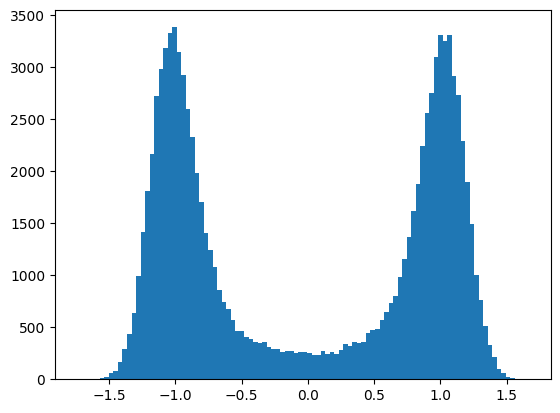

In [72]:
plt.hist(x_recon[:,1],bins = 100)

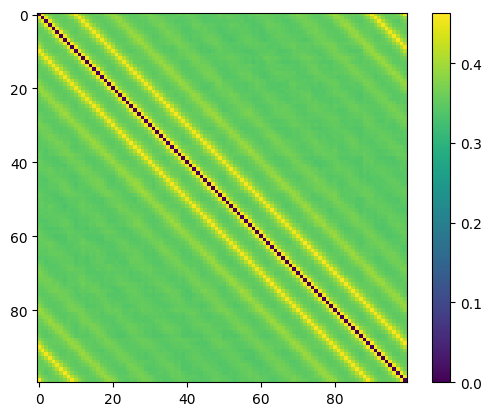

In [73]:
Jrecon = np.cov(x_recon.T)
Jrecon = -Jrecon +np.diag(np.diag(Jrecon))
plt.imshow(-Jrecon)
plt.colorbar()

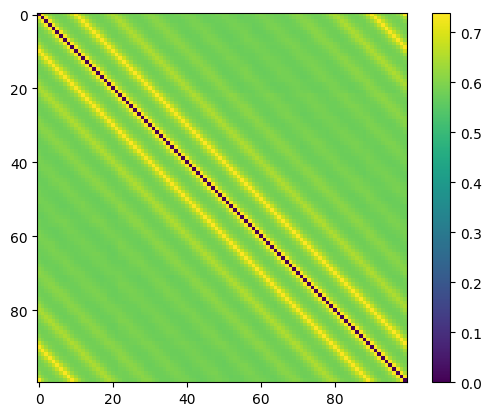

In [74]:
Jtrue = np.cov(data.T)
Jtrue = -Jtrue +np.diag(np.diag(Jtrue))
plt.imshow(-Jtrue)
plt.colorbar()